# Obtain detuning from FID

In [129]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import os

#absolute path of repo root
rel_path = os.getcwd()

In [130]:
omega = 6473000
FIDData = pd.read_csv(os.path.join(rel_path,f'data/FID_resonance/{str(omega)}.csv'))
buffer = 50
cutoff = np.argmax(np.diff(FIDData["v1"]))+buffer

In [131]:
#trim out saturated data
chan1 = FIDData["v1"][cutoff:].values
chan2 = FIDData["v2"][cutoff:].values
tlist = FIDData["t"][cutoff:].values

#adjust y axis (needed for getting maxima by squaring)
chan1 = np.subtract(chan1, np.mean(chan1[1500:]))
chan2 = np.subtract(chan2, np.mean(chan1[1500:]))

#tstep is 2e-6 (units of seconds)
tstep = tlist[1]-tlist[0]

In [132]:
def smooth(y, pts): #Rolling avg smoothing
    box = np.ones(pts)/pts
    yfilt=np.convolve(y,box,mode='same')
    return yfilt

In [133]:
chan1_smooth = smooth(chan1, 40)
chan2_smooth = smooth(chan2, 40)

## Find zeros

In [134]:
def next_zero(arr, start):
    for i in range(start,len(arr)-1):
        if not (np.sign(arr[i]) == np.sign(arr[i+1])):
            return i
    
def zeros(ydata, min_spacing, num = 7):
    zeros = []
    new_zero = -min_spacing
    for i in range(num):
        new_zero = next_zero(ydata, new_zero+min_spacing)
        zeros.append(new_zero)
    return zeros

In [135]:
zeros1 = zeros(chan1_smooth, 10)
zeros2 = zeros(chan2_smooth, 10)

spacing = zeros1[1]-zeros1[0]

zeros1 = zeros(chan1_smooth, round(spacing*1.5))
zeros2 = zeros(chan2_smooth, round(spacing*1.5))

0.148


Text(0, 0.5, '$M_XY$ (arb. u.)')

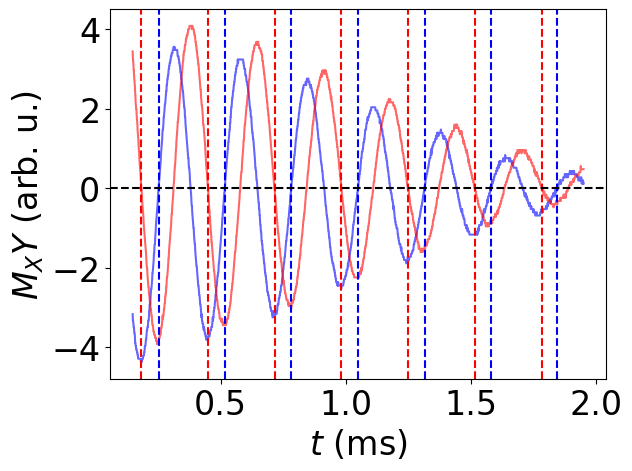

In [136]:
tlist_new=np.array(tlist)*1000
print(min(tlist_new))
plt.plot(tlist_new, chan1, color = "b", alpha = 0.6)
# plt.plot(tlist, chan1_smooth, color = "b")
plt.plot(tlist_new, chan2, color = "r", alpha = 0.6)
# plt.plot(tlist, chan2_smooth, color = "r")
for zero in zeros1:
    plt.axvline(tlist_new[zero], color = "b", linestyle = "--")
for zero in zeros2:
    plt.axvline(tlist_new[zero], color = "r", linestyle = "--")
plt.axhline(y=0,color='k',xmin=0,xmax=max(tlist_new),linestyle='--')
plt.tick_params(labelsize=24)
plt.xlabel(r"$t$ (ms)",fontsize=24)
plt.ylabel("$M_XY$ (arb. u.)",fontsize=24)

In [137]:
spacing1 = np.mean(np.diff(zeros1))
spacing2 = np.mean(np.diff(zeros2))
spacing = np.mean([spacing1, spacing2])
## Detuning (Hz)
delta_omega = 1/(spacing*tstep)

In [138]:
#Resonant frequency
omega_0 = omega + delta_omega
print(omega_0)

6476759.39849624


## Automatic processing

In [139]:
freq_data = {}
omegas = list(sorted([int(Path(f).stem) for f in os.listdir(os.path.join(rel_path,"data/FID_resonance/"))]))

def get_detuning(omega):

    FIDData = pd.read_csv(os.path.join(rel_path,f"data/FID_resonance/{str(omega)}.csv"))
    buffer = 200
    cutoff = np.argmax(np.diff(FIDData["v1"]))+buffer
    #trim out saturated data
    chan1 = FIDData["v1"][cutoff:].values
    chan2 = FIDData["v2"][cutoff:].values
    tlist = FIDData["t"][cutoff:].values

    #adjust y axis (needed for getting maxima by squaring)
    chan1 = np.subtract(chan1, np.mean(chan1[cutoff:]))
    chan2 = np.subtract(chan2, np.mean(chan1[cutoff:]))

    #tstep is 2e-6 (units of seconds)
    tstep = tlist[1]-tlist[0]

    chan1_smooth = smooth(chan1, 10)
    chan2_smooth = smooth(chan2, 10)

    zeros1 = zeros(chan1_smooth, 1, 2)
    zeros2 = zeros(chan2_smooth, 1, 2)

    spacing = zeros1[1]-zeros1[0]

    zeros1 = zeros(chan1_smooth, round(spacing*1.5), 2)
    zeros2 = zeros(chan2_smooth, round(spacing*1.5), 2)

    spacing = np.mean([zeros1[1]-zeros1[0], zeros2[1]-zeros2[0]])
    return 1/(spacing*tstep)

In [140]:
for omega in omegas:
    freq_data[omega] = get_detuning(omega)

In [141]:
freq_data

{6473000: 3745.318352059834,
 6474000: 2762.430939226452,
 6475000: 1730.1038062284254,
 6478000: 1199.040767386062,
 6479000: 2224.694104560689}

In [142]:
linear = lambda x,b : np.abs(x-b)
popt, pcov = sc.optimize.curve_fit(linear, list(freq_data.keys()), list(freq_data.values()))

(-0.1, 5.0)

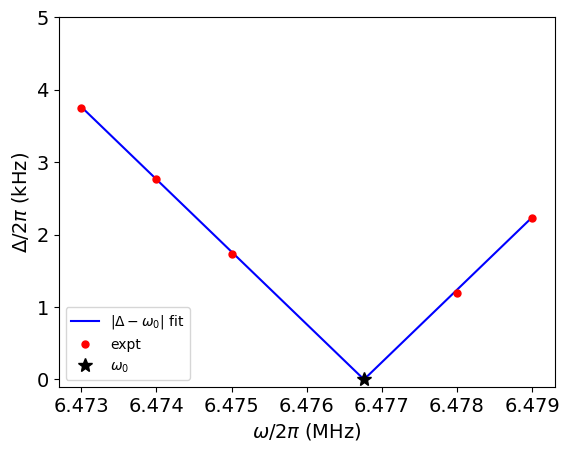

In [149]:
xlist = np.linspace(min(freq_data.keys()), max(freq_data.keys()), 100)
plt.plot(xlist*1e-6, linear(xlist, *popt)*1e-3,color='b',label='$|\Delta-\omega_0|$ fit')
plt.plot(np.array(list(freq_data.keys())[:3])*1e-6, np.array(list(freq_data.values()))[:3]*1e-3, '.r', markersize=10, linestyle = "None", label='expt')
plt.plot(np.array(list(freq_data.keys())[3:])*1e-6, np.array(list(freq_data.values()))[3:]*1e-3, '.r', markersize=10, linestyle = "None")
plt.plot(popt[0]*1e-6,0,'*k',markersize=10, label='$\omega_0$')
plt.ylabel('$\Delta/2\pi$ (kHz)',fontsize=14)
plt.xlabel('$\omega/2\pi$ (MHz)',fontsize=14)
plt.legend(loc=3)
plt.tick_params(labelsize=14)
plt.ylim(-0.1,5)

In [ ]:
popt[0]

6476764.229017855

In [ ]:
np.sqrt(pcov.item())

11.791509196880014